In [216]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt

from scipy import randn

In [217]:
data = pd.read_csv('data/prices.txt')

In [218]:
data.head()

,area,rooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


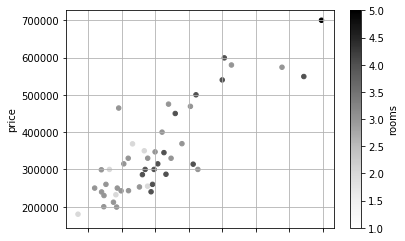

In [219]:
plot1 = data.plot(kind='scatter', x='area', y='price', c='rooms', grid=True)
#plot1.set_facecolor("gray")

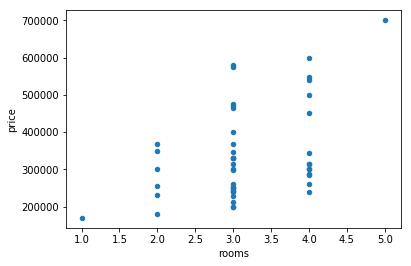

In [220]:
data.plot(kind = 'scatter', x = 'rooms', y='price')

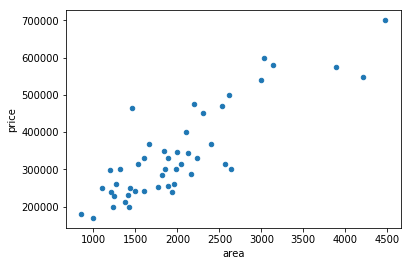

In [221]:
data.plot(kind = 'scatter', x = 'area', y='price')

In [222]:
X = data[['area', 'rooms']]
y = np.array(list(map(float, data['price'])))

In [223]:
def standard_transform(x):
    return StandardScaler().fit_transform(x)

def append_one(x):
    return np.append(np.ones(len(x)).reshape((len(x), 1)), x, axis=1)

In [224]:
scalerX = StandardScaler()
scalerY = StandardScaler()
initX = X
X = scalerX.fit_transform(X)
X = append_one(X)
initX = append_one(initX)

y = scalerY.fit_transform(y.reshape(len(y), 1)).reshape(len(y))


In [225]:
def first_price(p):    
    return scalerY.inverse_transform([p])[0]    
    
def get_mse(regressor, xs, ys):    
    predicted = np.apply_along_axis(regressor.predict, 1, xs)
    return sqrt((
        (scalerY.inverse_transform(predicted) - scalerY.inverse_transform(ys)) ** 2)
                .mean())


In [226]:
class LinearRegression:
    def __init__(self, w = None, linearCoef = 0.5, numIter = 100):
        self.baseW = w
        self.linearCoef = linearCoef   
        self.numIter = numIter
        
    def _grad_descend(self):
        Xt = self.X.transpose()
        m = self.X.shape[0]
        mse = None
        w = self.baseW
        for i in range(self.numIter):
            h = np.dot(self.X, w)
            diff = h - self.y
            grad = np.dot(Xt, diff) / m            
            w -= (self.linearCoef[i] * grad)
            
        self.w = w      
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self._grad_descend()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w


In [227]:
m, n = X.shape
w = np.ones(n)
numIter = 100
linearCoef = [0.5] * numIter
linearReg = LinearRegression(w = w, linearCoef = linearCoef, numIter = numIter)
linearReg.fit(X, y)

print (linearReg.weights())
print (get_mse(linearReg, X, y))

[ -9.89708505e-17   8.84765988e-01  -5.31788197e-02]
63926.20824986929


In [228]:
def show_separator(weights):
    tX = X.transpose()
    for i, x in enumerate(initX.transpose()[1:], 1):                
        plt.scatter(x, scalerY.inverse_transform(y)) 
        plt.plot([x.min(), x.max()], [first_price(weights[0] + weights[i] * tX[i].min()),
                                      first_price(weights[0] + weights[i] * tX[i].max())])      
        plt.ylabel('Price')
        plt.xlabel('%s' % ['area', 'rooms'][i-1])
        plt.show()

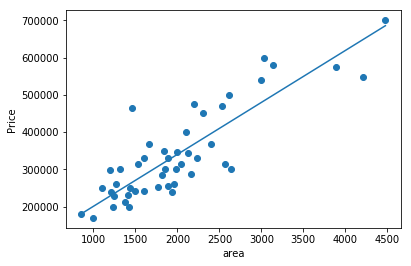

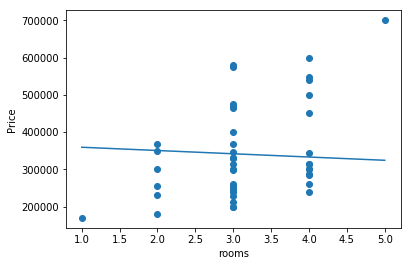

In [229]:
linW = linearReg.weights()
show_separator(linW)

In [230]:
np.random.seed(53)

class GeneticReg:
    def __init__(self, numIter = 100, popSize = 50, mutationCount = 5):        
        self.numIter = numIter
        self.popSize = popSize
        self.mutationCount = mutationCount        
        
    def mutation(self, pop):            
        return pop + randn(*pop.shape)
    
    def gen_optimize(self):
        m, n = self.X.shape
        pop = np.zeros((self.popSize, n))
        pops = []
        mses = []        
       
        for i in range(self.numIter):
            pops = pop.copy()
            for j in range(self.mutationCount):
                pops = np.append(pops, self.mutation(pop), axis=0)
                        
            mses = []
            for j, single_pop in enumerate(pops):
                h = np.dot(X, single_pop)
                diff = h - y
                mse = np.sum(diff ** 2) / (m)
                mses.append((mse, j))
            mses = sorted(mses)
            pop = pops[mses[0][1]].reshape(1, len(pops[mses[0][1]]))
            
            for _, j in mses[1:self.popSize]:
                pop = np.append(pop, pops[j].reshape(1, len(pops[j])), axis=0)                                    
        
        self.w = pops[mses[0][1]]
    
    def fit(self, X, y):
        self.X = X
        self.y = y      
        self.gen_optimize()

    def predict(self, X):               
        return np.dot(X, self.w)
    
    def weights(self):
        return self.w

In [231]:
genReg = GeneticReg(numIter = 1000, popSize = 10, mutationCount = 5)
genReg.fit(X, y)
print (get_mse(genReg, X, y))
print (genReg.weights())

64139.04293544999
[ -9.70076036e-06   8.34965832e-01  -1.64146213e-02]


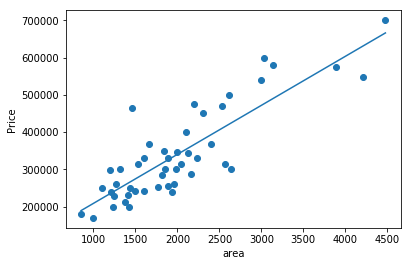

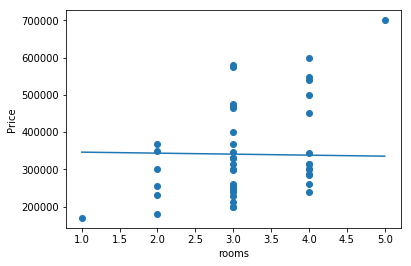

In [232]:
genW = genReg.weights()
show_separator(genW)

In [233]:
exX = [[2100., 3.]]
exX = append_one(scalerX.transform(exX))

print (first_price(linearReg.predict(exX)))
print (first_price(genReg.predict(exX)))

[ 355726.2676425]
[ 353918.60494226]
